# LAB 3.1 - CNS (TDNN and RNN)

Import of libraries, fix of random seed and device.


In [1]:
import json
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from typing import Callable
from tqdm.notebook import tqdm
import torch
from torchvision import datasets

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda'

Loading of dataset NARMA10.

In [2]:
with open(f'NARMA10.csv') as file:
    data = file.read().split('\n')[:-1]
    X_narma10 = torch.Tensor([float(r) for r in data[0].split(',')]).to(device)
    Y_narma10 = torch.Tensor([float(r) for r in data[1].split(',')]).to(device)

X_narma10.shape, Y_narma10.shape

(torch.Size([10000]), torch.Size([10000]))

Split in train and test set for each X and Y data.

In [3]:
tr_size = 5000

TR_X_narma10 = X_narma10[:tr_size]
TR_Y_narma10 = Y_narma10[:tr_size]
TS_X_narma10 = X_narma10[tr_size:]
TS_Y_narma10 = Y_narma10[tr_size:]

TR_X_narma10.shape, TR_Y_narma10.shape, TS_X_narma10.shape, TS_Y_narma10.shape

(torch.Size([5000]),
 torch.Size([5000]),
 torch.Size([5000]),
 torch.Size([5000]))

Functions able to provide an easiest way to plot the results.

In [4]:
def _base_plot(
        elements: list[tuple],
        title: str = '',
        xlabel: str = '',
        ylabel: str = '',
        xscale=None,
        yscale=None,
        save_name=None
) -> None:
    """Function able to plot a list of elements."""
    plt.figure(figsize=(20, 10))
    plt.title(title)
    for line, label in elements:
        plt.plot(line, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xscale is not None:
        plt.xscale(xscale)
    if yscale is not None:
        plt.yscale(yscale)
    plt.grid()
    plt.legend()
    if save_name is not None:
        plt.savefig(f'tdnn_and_rnn_plots/{save_name}.png')
    plt.show()


def plot_tr(
        data: torch.Tensor,
        prediction: torch.Tensor,
        save_name: str = None
) -> None:
    """Function able to plot the training y data and predictions to make a comparison between them."""
    if save_name is not None:
        save_name = f'{save_name}_train'
    prediction = prediction.reshape(-1).tolist()
    _base_plot(
        [
            (data[-len(prediction):], 'time series'),
            (prediction, 'prediction'),
        ],
        title='Time series of training set',
        xlabel='X',
        ylabel='Y',
        save_name=save_name,
        xscale='log',
    )


def plot_ts(
        data: torch.Tensor,
        prediction: torch.Tensor,
        save_name: str = None
) -> None:
    """Function able to plot the test y data and predictions to make a comparison between them."""
    if save_name is not None:
        save_name = f'{save_name}_test'
    prediction = prediction.reshape(-1).tolist()
    _base_plot(
        [
            (data[-len(prediction):], 'time series'),
            (prediction, 'prediction'),
        ],
        title='Time series of test set',
        xlabel='X',
        ylabel='Y',
        save_name=save_name,
        xscale='log',
    )


def plot_loss(
        tr_loss: list,
        ts_loss: list,
        save_name: str = None
) -> None:
    """Function able to plot the learning curve of training and test losses."""
    if save_name is not None:
        save_name = f'{save_name}_loss'
    _base_plot(
        [
            (tr_loss, 'TR loss'),
            (ts_loss, 'TS loss'),
        ],
        title='Loss (MSE) for epochs',
        xlabel='Epochs',
        ylabel='Loss (MSE)',
        save_name=save_name,
        yscale='log',
    )


def general_plot(
        train_loss: list,
        ts_loss: list,
        TR_Y: torch.Tensor,
        train_pred: torch.Tensor,
        TS_Y: torch.Tensor,
        eval_pred: torch.Tensor,
        save_name: str = None
) -> None:
    """Function able to plot all results of subplots related to learning curve, training data and test data."""
    plot_loss(train_loss, ts_loss, save_name=save_name)
    plot_tr(data=TR_Y, prediction=train_pred[-1], save_name=save_name)
    plot_ts(data=TS_Y, prediction=eval_pred[-1], save_name=save_name)

Train function able to fit a model given in input.

In [5]:
def train(
        model: torch.nn.Module,
        TR: tuple[torch.Tensor, torch.Tensor],
        TS: tuple[torch.Tensor, torch.Tensor],
        epochs: int = 10,
        sgd_config: dict = {},
        tqdm=None,
        save_name: str = None,
        device: str = 'cpu',
) -> tuple:
    """
    Function able to train a given model.

    model: Model to train.
    TR: Tuple composed by X train and Y train torch tensors.
    TS: Tuple composed by X test and Y test torch tensors.
    epochs: Number of epochs of training.
    sgd_config: Dictionary containing sgd configurations (lr and momentum).
    tqdm: TQDM object to show the progressbar. It is None when progressbar is not shown.
    save_name: Name given to save the torch model and data in a file. If it is None the file is not created.
    device: Name of device to use for computation.

    returns:
        tuple: Results of training. In particular the tuple is composed by 4 variables:
            - train_loss: List of MSE loss of training set computed for each epoch.
            - test_loss: List of MSE loss of test set computed for each epoch.
            - train_preds: List of predictions of training set for each epoch.
            - test_preds: List of predictions of test set for each epoch.
    """
    optimizer = torch.optim.SGD(model.parameters(), **sgd_config)
    criterion = torch.nn.MSELoss()
    train_loss, test_loss = [], []
    train_preds, test_preds = [], []
    X_TR, Y_TR = TR
    X_TS, Y_TS = TS
    model.eval()
    test_loss.append(criterion(model(X_TS), Y_TS).item())

    iterable = range(epochs)
    if tqdm is not None:
        iterable = tqdm(iterable)
    for _ in iterable:
        model.train()
        optimizer.zero_grad()
        pred_tr = model(X_TR)
        loss_tr = criterion(pred_tr, Y_TR)
        loss_tr.backward()
        optimizer.step()
        train_loss.append(loss_tr.item())
        train_preds.append(pred_tr.cpu())

        model.eval()
        pred_vl = model(X_TS)
        test_loss.append(criterion(pred_vl, Y_TS).item())
        test_preds.append(pred_vl.cpu())

    train_loss.append(criterion(model(X_TR), Y_TR).item())
    if save_name is not None:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss[-1],
        }, f'tdnn_and_rnn_variables/{save_name}_model_and_tr_info.pt')
    return train_loss, test_loss, train_preds, test_preds

Gridsearch function able to find the best configuration for a model created in a `train_func` function callback, train the model with the best configuration and test it on test set.

In [6]:
def gridsearch(
        train_func: Callable,
        configs: dict,
        TR: tuple[torch.Tensor, torch.Tensor],
        TS: tuple[torch.Tensor, torch.Tensor],
        epochs: int = 100,
        vl_tr_size: int = 4000,
        attempts_for_config: int = 1,
        save_name: str = None,
        device: str = 'cpu',
) -> tuple:
    """
    Gridsearch function able to find the best hyperparameters configuration, train the model with the best config and test it.

    train_func: Function able to create a model and train it given a config, a train and validation set and a number of epochs.
    configs: Hyperparameters configurations to investigate to find the best one that minimizes the loss on validation set. In particular this is a dictionary of lists for each hyperparam to investigate that is transformed by this function in a list of dictionaries.
    TR: Training set data (X, Y).
    TS: test set data (X, Y).
    epochs: Number of epochs of training both for model selection and model evaluation.
    vl_tr_size: Number of example to use in training set of model selection phase. It is useful to split training set in training and validation set.
    attempts_for_config: Number of attempts to do for each configuration. The loss that it's minimized is the mean of each loss of each attempt.
    save_name: Name used for saving the file related to mse info (mse of training, validation and test set).
    device: Name of device to use for computation.

    returns: A tuple of 4 variables related to the result of training function during the model evaluation phase (training on entire training set and test on test set).
    """
    configs = [dict(zip(configs.keys(), t)) for t in itertools.product(*configs.values())]
    best_config = {}
    best_loss = None
    X_TR, Y_TR = TR
    for i, config in enumerate(tqdm(configs)):
        vl_loss = 0
        for j in range(attempts_for_config):
            _, tdnn_eval_loss, _, _ = train_func(
                config,
                (X_TR[:vl_tr_size], Y_TR[:vl_tr_size]),
                (X_TR[vl_tr_size:], Y_TR[vl_tr_size:]),
                epochs=epochs,
                device=device,
            )
            vl_loss += tdnn_eval_loss[-1]
        vl_loss /= attempts_for_config
        print(f'{i + 1}/{len(configs)} - Tried config {config} with loss {vl_loss}')
        if best_loss is None or vl_loss < best_loss:
            best_config = config
            best_loss = vl_loss
    print(f'Best config: {best_config} with loss {best_loss}')
    print('Retraining...')
    train_loss, eval_loss, train_preds, eval_preds = train_func(
        best_config,
        TR,
        TS,
        epochs=epochs,
        tqdm=tqdm,
        save_name=save_name,
        device=device,
    )

    if save_name is not None:
        mse_data = {
            'train_mse': train_loss[-1],
            'validation_mse': best_loss,
            'test_mse': eval_loss[-1]
        }
        print(mse_data)
        with open(f'tdnn_and_rnn_variables/{save_name}_mse_data.json', 'w') as file:
            json.dump(mse_data, file)

    return train_loss, eval_loss, train_preds, eval_preds

### TDNN

TDNN pytorch model.

In [7]:
class TDNN(torch.nn.Module):
    """
    Class of TDNN model.
    """

    def __init__(self, window: int, hidden_size: int, output_size: int, n_layers: int = 1, device: str = 'cpu') -> None:
        """
        TDNN constructor method.

        window: Window of TDNN that is related to the number of previous time steps seen in the past.
        hidden_size: Size of hidden state.
        output_size: Size of output value.
        n_layers: Number of hidden layers. Default this is 1.
        """
        super(TDNN, self).__init__()
        hidden_layers = [torch.nn.Linear(window + 1, hidden_size)]
        for _ in range(n_layers - 1):
            hidden_layers.append(torch.nn.Linear(hidden_size, hidden_size).to(device))
        self.hidden_layers = torch.nn.Sequential(*hidden_layers).to(device)
        self.output_layer = torch.nn.Linear(hidden_size, output_size).to(device)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward function used to the forward phase of pytorch module.

        X: Input data.

        returns:
            torch.Tensor: Output data.
        """
        for hidden_layer in self.hidden_layers:
            preactivation = hidden_layer(X)
            X = torch.nn.functional.tanh(preactivation)
        return self.output_layer(X)


TDNN(10, 100, 1, n_layers=2)

TDNN(
  (hidden_layers): Sequential(
    (0): Linear(in_features=11, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
)

TDNN train function.

In [8]:
def train_tdnn(
        config: dict,
        TR: torch.Tensor,
        TS: torch.Tensor,
        epochs: int = 10,
        tqdm=None,
        save_name: str = None,
        device: str = 'cpu',
) -> tuple:
    """
    Function used to train the TDNN model. It wraps the general train function.

    config: Dictionary of hyperparameters.
    TR: Training set.
    TS: Test set.
    epochs: Number of epochs.
    tqdm: Object used to show the progressbar.
    save_name: Able to provide the title of file containing pytorch model and training info.
    device: Name of device to use for computation.

    returns:
        tuple: Train results.
    """
    window = config['window']
    model = TDNN(window, config['hidden_size'], 1, n_layers=config['n_layers'], device=device)
    sets = []
    for X, Y in [TR, TS]:
        X = torch.unsqueeze(X.unfold(0, window + 1, 1), 0)
        Y = Y[window:].reshape(1, -1, 1)
        sets.append((X, Y))
    return train(model, sets[0], sets[1], epochs=epochs, tqdm=tqdm, save_name=save_name, device=device, sgd_config={
        'lr': config['lr'],
        'momentum': config['momentum'],
    })

TDNN gridsearch and results.

  0%|          | 0/24 [00:00<?, ?it/s]

1/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.0044513573870062825
2/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.00444963900372386
3/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.5} with loss 0.004484765697270632
4/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.004662542045116425
5/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.5} with loss 0.004451035428792239
6/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.2} with loss 0.0044479090720415115
7/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.5} with loss 0.004616387002170086
8/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.2} wi

  0%|          | 0/1000 [00:00<?, ?it/s]

{'train_mse': 0.0010467508109286427, 'validation_mse': 0.0010900419903919101, 'test_mse': 0.0010774501133710146}


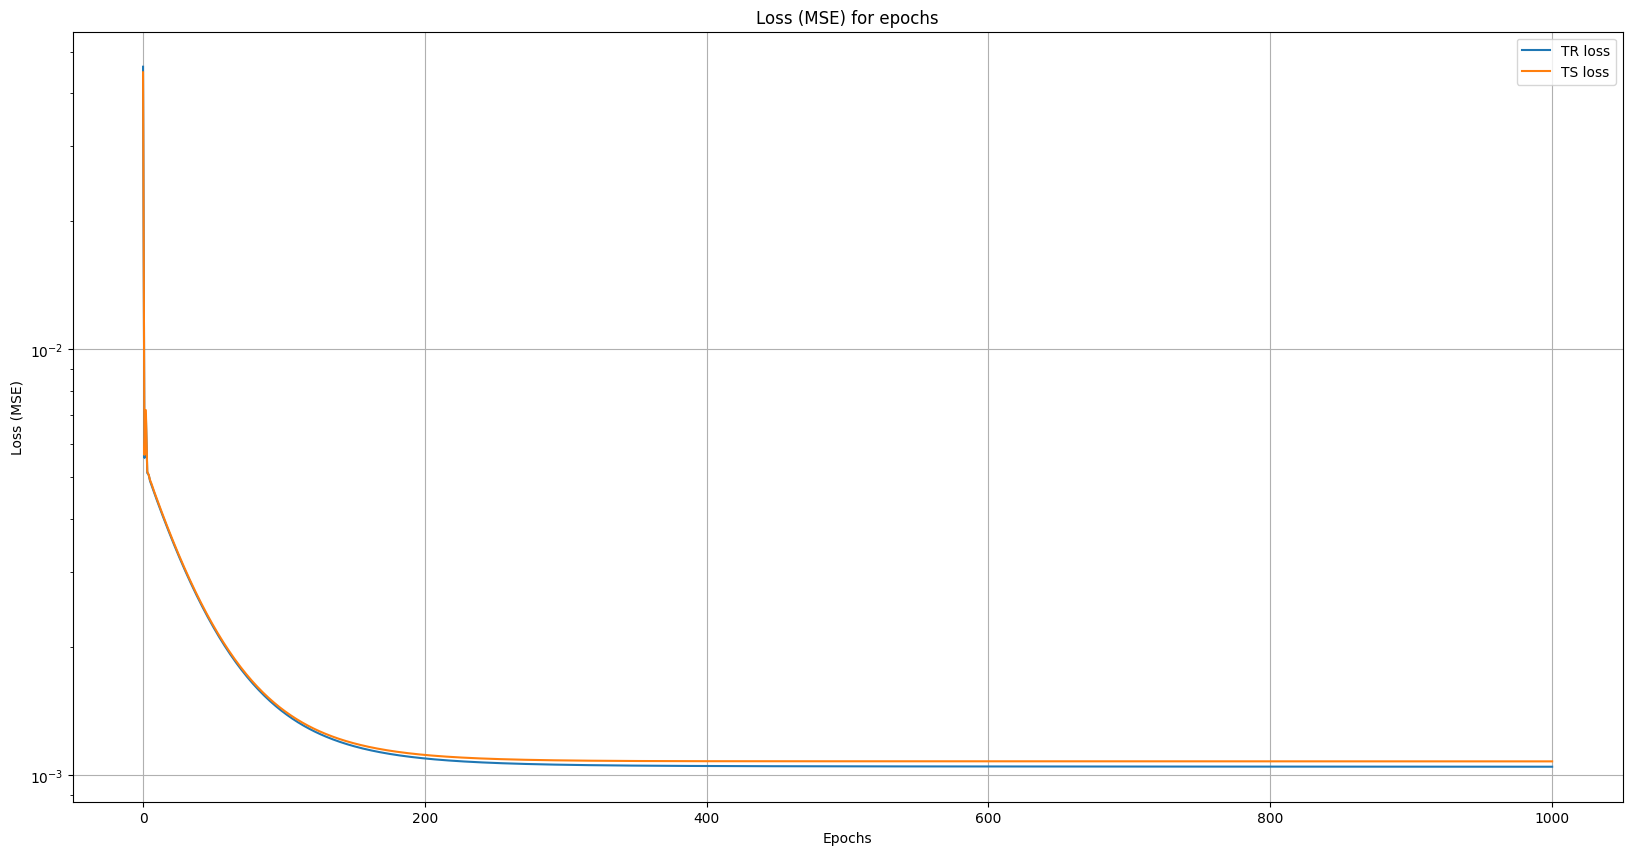

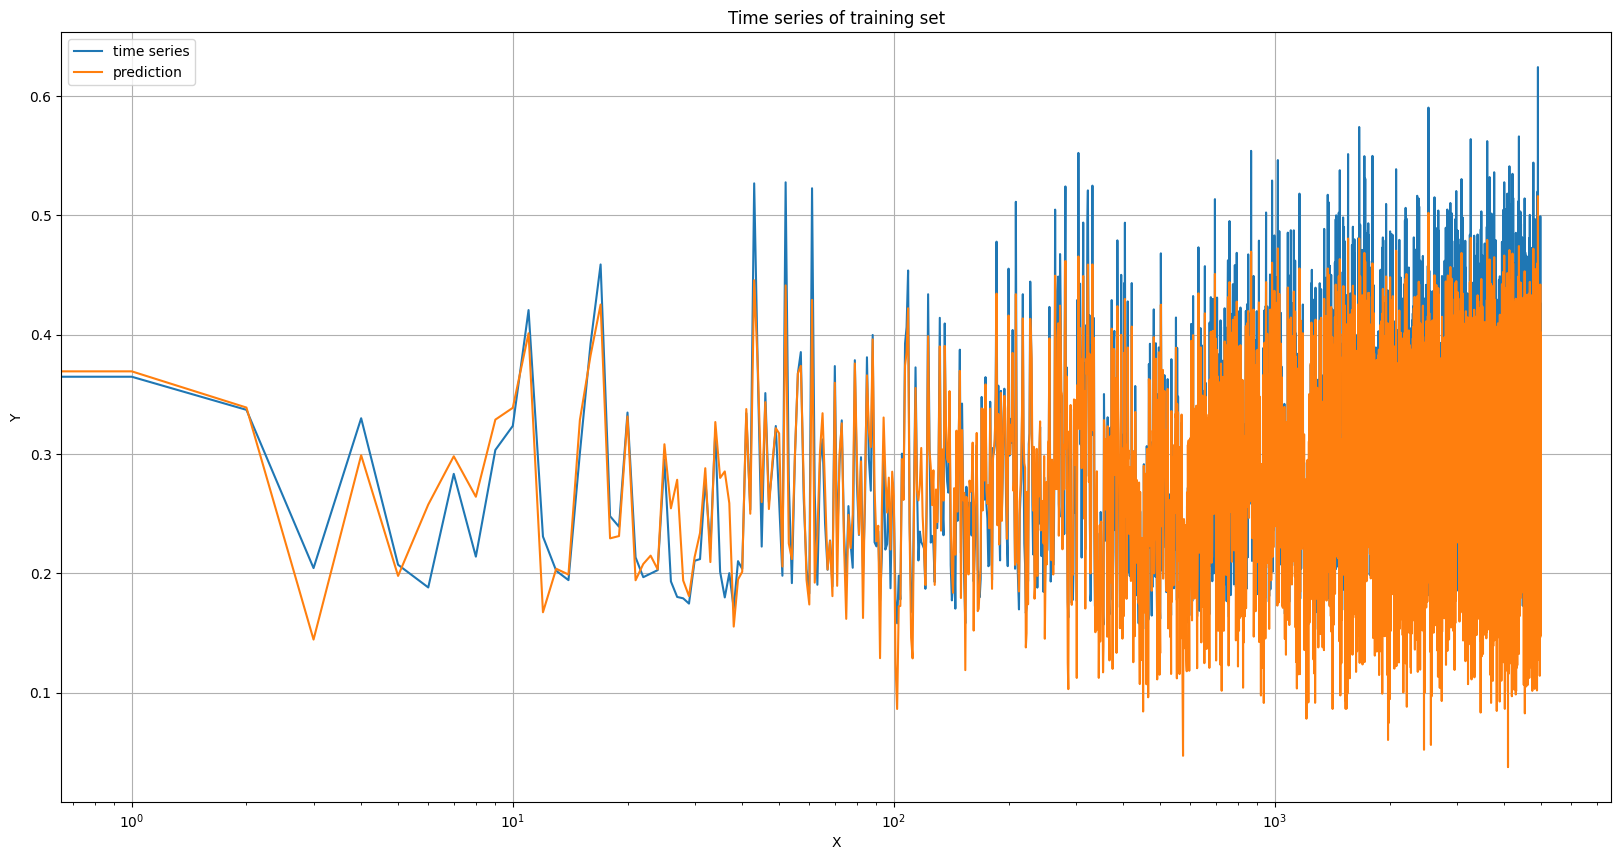

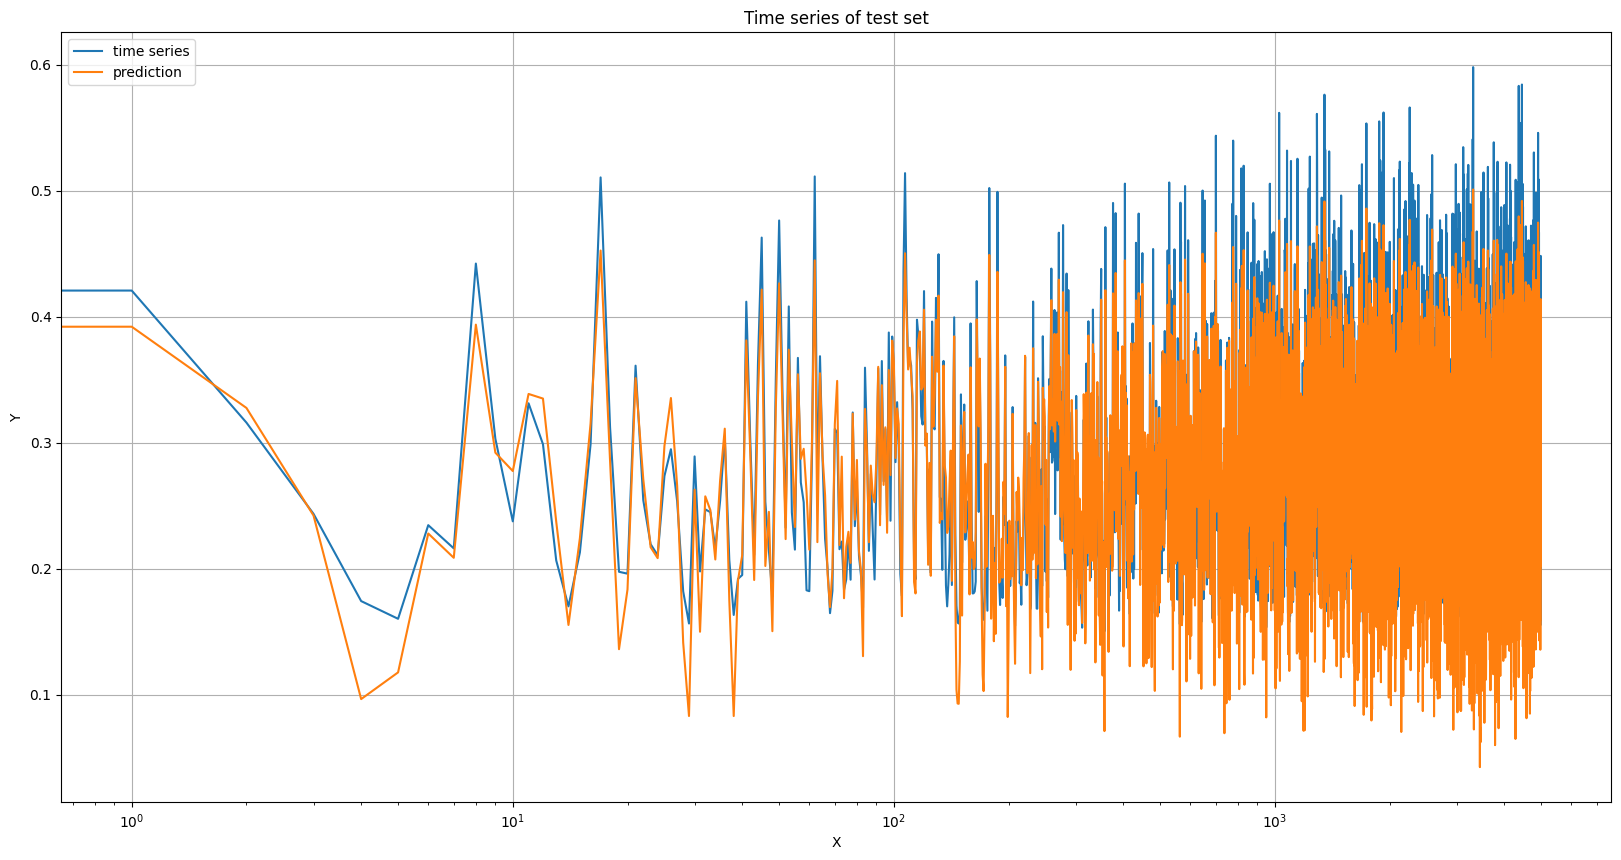

In [9]:
tdnn_save_name = 'tdnn_narma10'

tdnn_train_loss, tdnn_ts_loss, tdnn_train_pred, tdnn_eval_pred = gridsearch(
    train_func=train_tdnn,
    configs=dict(
        window=[8, 10, 12],
        hidden_size=[100],
        n_layers=[1, 2],
        lr=[0.1, 0.01],
        momentum=[0.5, 0.2],
    ),
    TR=(TR_X_narma10, TR_Y_narma10),
    TS=(TS_X_narma10, TS_Y_narma10),
    epochs=1000,
    vl_tr_size=4000,
    attempts_for_config=5,
    save_name=tdnn_save_name,
    device=device,
)

general_plot(tdnn_train_loss, tdnn_ts_loss, TR_Y_narma10.cpu(), tdnn_train_pred, TS_Y_narma10.cpu(), tdnn_eval_pred,
             save_name=tdnn_save_name)

### RNN

RNN pytorch model.

In [10]:
class RNN(torch.nn.Module):
    """
    Class of RNN model.
    """

    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            output_size: int,
            stateful: bool = True,
            n_layers: int = 1,
            device: str = 'cpu',
    ) -> None:
        """
        RNN constructor method.

        input_size: Size of input value.
        hidden_size: Size of hidden state.
        output_size: Size of output value.
        stateful: Boolean set to true if it's want to use the final training hidden state as initial hidden state of evaluation.
        n_layers: Number of hidden layers. Default this is 1.
        device: Name of device to use for computation.
        """
        super(RNN, self).__init__()
        self.recoursive_layer = torch.nn.RNN(input_size, hidden_size, num_layers=n_layers).to(device)
        self.output_layer = torch.nn.Linear(hidden_size, output_size).to(device)
        self.stateful = stateful
        self.h = None

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward function used to the forward phase of pytorch module.

        X: Input data.

        returns:
            torch.Tensor: Output data.
        """
        state, h = self.recoursive_layer(X, self.h)
        if self.stateful and self.training:
            self.h = h.detach()
        return self.output_layer(state)


RNN(1, 100, 1)

RNN(
  (recoursive_layer): RNN(1, 100)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
)

RNN train function.

In [11]:
def train_rnn(
        config: dict,
        TR: tuple[torch.Tensor, torch.Tensor],
        TS: tuple[torch.Tensor, torch.Tensor],
        epochs: int = 10,
        tqdm=None,
        save_name: str = None,
        device: str = 'cpu',
) -> tuple:
    """
    Function used to train the RNN model. It wraps the general train function.

    config: Dictionary of hyperparameters.
    TR: Training set.
    TS: Test set.
    epochs: Number of epochs.
    tqdm: Object used to show the progressbar.
    save_name: Able to provide the title of file containing pytorch model and training info.
    device: Name of device to use for computation.

    returns:
        tuple: Train results.
    """
    model = RNN(TR[0].shape[-1], config['hidden_size'], TR[1].shape[-1], n_layers=config['n_layers'], device=device)
    return train(model, TR, TS, epochs=epochs, tqdm=tqdm, save_name=save_name, device=device, sgd_config={
        'lr': config['lr'],
        'momentum': config['momentum'],
    })

RNN gridsearch and results.

  0%|          | 0/8 [00:00<?, ?it/s]

1/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.0044389758259058
2/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.004490434192121029
3/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.5} with loss 0.006353601968536775
4/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.006584458518773317
5/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.5} with loss 0.0043196592790385084
6/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.2} with loss 0.004424501055230697
7/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.5} with loss 0.006430871784687042
8/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.2} with loss 0.006865997177859147
Best config: {'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.5} with los

  0%|          | 0/1000 [00:00<?, ?it/s]

{'train_mse': 0.004512135870754719, 'validation_mse': 0.0043196592790385084, 'test_mse': 0.004164508543908596}


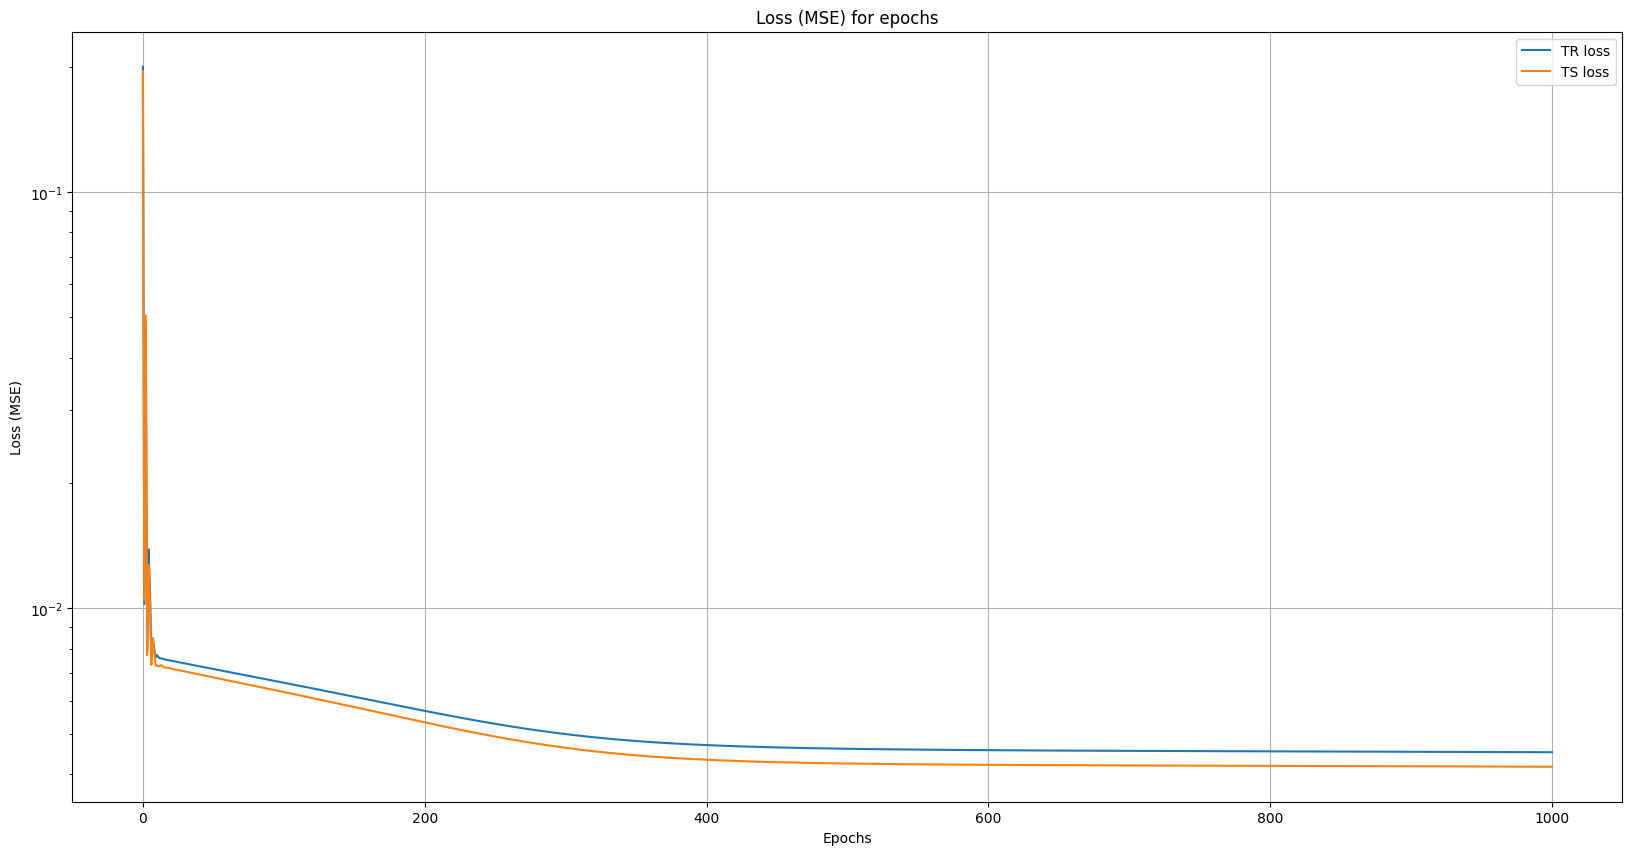

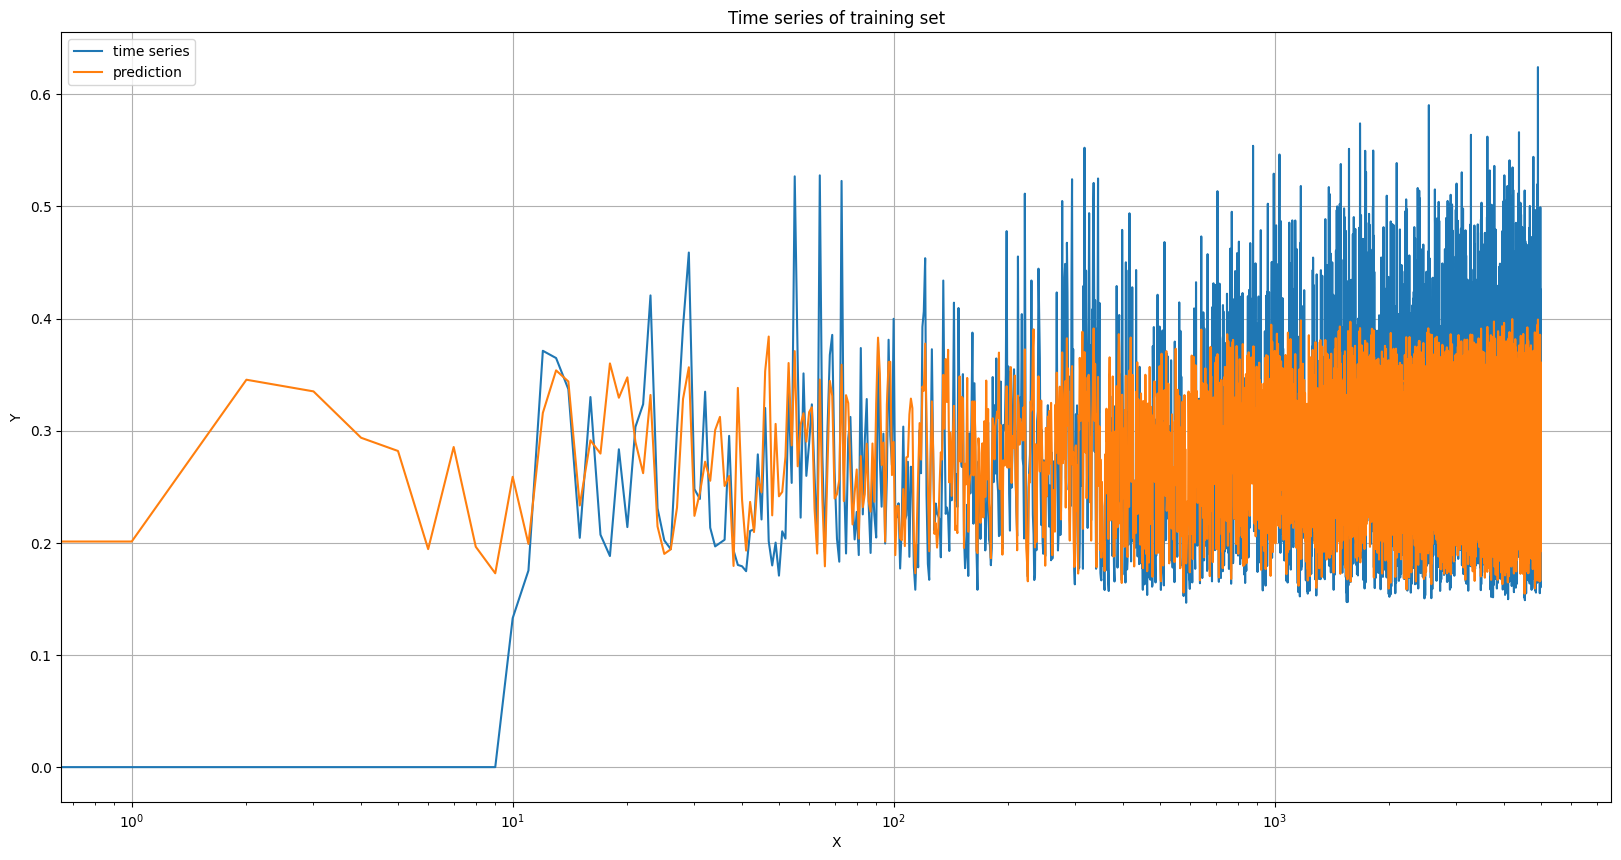

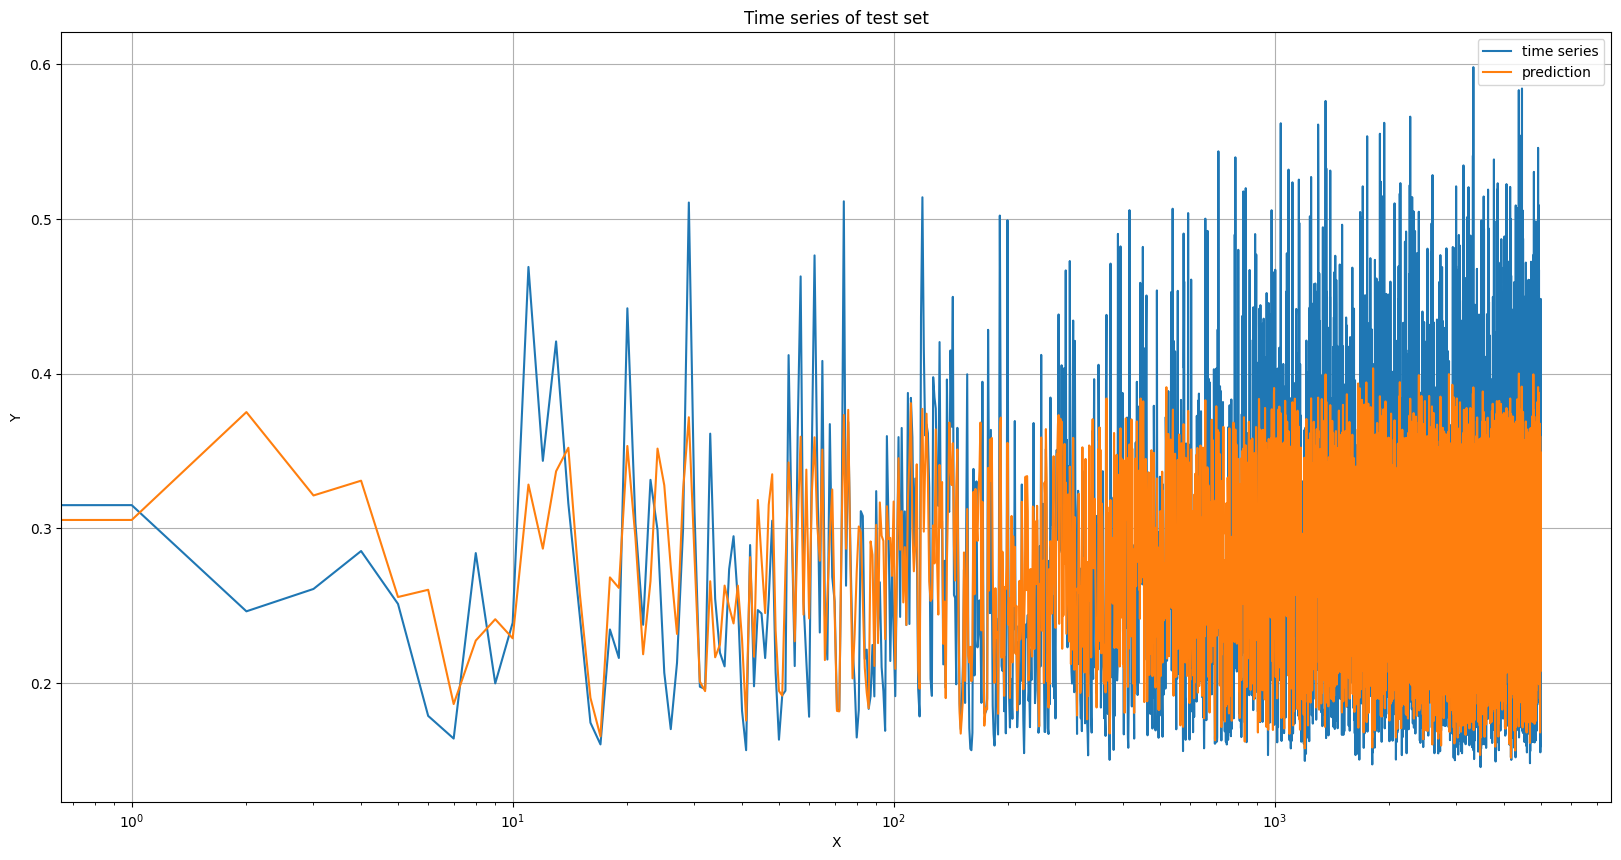

In [12]:
rnn_save_name = 'rnn_narma10'

rnn_train_loss, rnn_ts_loss, rnn_train_pred, rnn_eval_pred = gridsearch(
    train_func=train_rnn,
    configs=dict(
        hidden_size=[100],
        n_layers=[1, 2],
        lr=[0.1, 0.01],
        momentum=[0.5, 0.2],
    ),
    TR=(TR_X_narma10.reshape(-1, 1, 1), TR_Y_narma10.reshape(-1, 1, 1)),
    TS=(TS_X_narma10.reshape(-1, 1, 1), TS_Y_narma10.reshape(-1, 1, 1)),
    epochs=1000,
    vl_tr_size=4000,
    attempts_for_config=3,
    save_name=rnn_save_name,
    device=device,
)

general_plot(rnn_train_loss, rnn_ts_loss, TR_Y_narma10.cpu(), rnn_train_pred, TS_Y_narma10.cpu(), rnn_eval_pred,
             save_name=rnn_save_name)

# Bonus track 1 - Mackey-glass 17 task

Mackey-glass 17 task dataset loading and split in train and test set.

In [13]:
tr_size = 5000

with open(f'MG17.csv') as file:
    data = file.read().split('\n')[:-1][0]
    data = torch.Tensor([float(r) for r in data.split(',')])
    TR_mg17 = data[:tr_size].to(device)
    TS_mg17 = data[tr_size:].to(device)

TR_X_mg17 = TR_mg17[:-1]
TR_Y_mg17 = TR_mg17[1:]
TS_X_mg17 = TS_mg17[:-1]
TS_Y_mg17 = TS_mg17[1:]

TR_X_mg17.shape, TR_Y_mg17.shape, TS_X_mg17.shape, TS_Y_mg17.shape

(torch.Size([4999]),
 torch.Size([4999]),
 torch.Size([4999]),
 torch.Size([4999]))

### TDNN

TDNN gridsearch and results.

  0%|          | 0/24 [00:00<?, ?it/s]

1/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.00021490462531801314
2/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.0002767850673990324
3/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.5} with loss 0.0009113140171393752
4/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.0010504778125323354
5/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.5} with loss 0.00022535751049872487
6/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.2} with loss 0.0003055829205550253
7/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.5} with loss 0.0008997421362437307
8/24 - Tried config {'window': 8, 'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum':

  0%|          | 0/1000 [00:00<?, ?it/s]

{'train_mse': 0.00019657016673590988, 'validation_mse': 0.00016593730251770466, 'test_mse': 0.00019567414710763842}


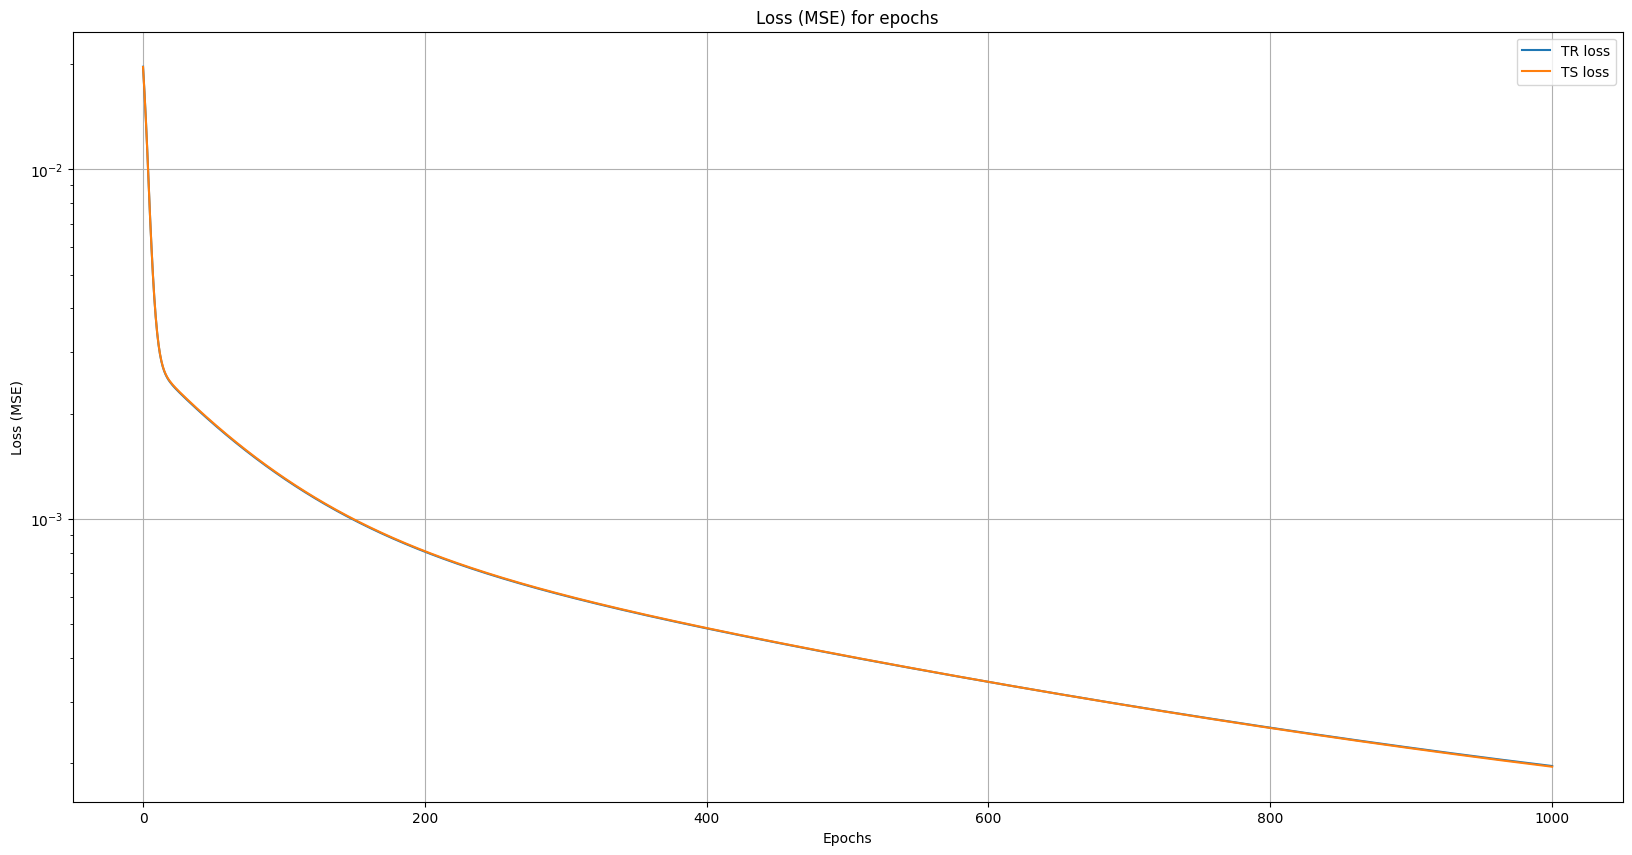

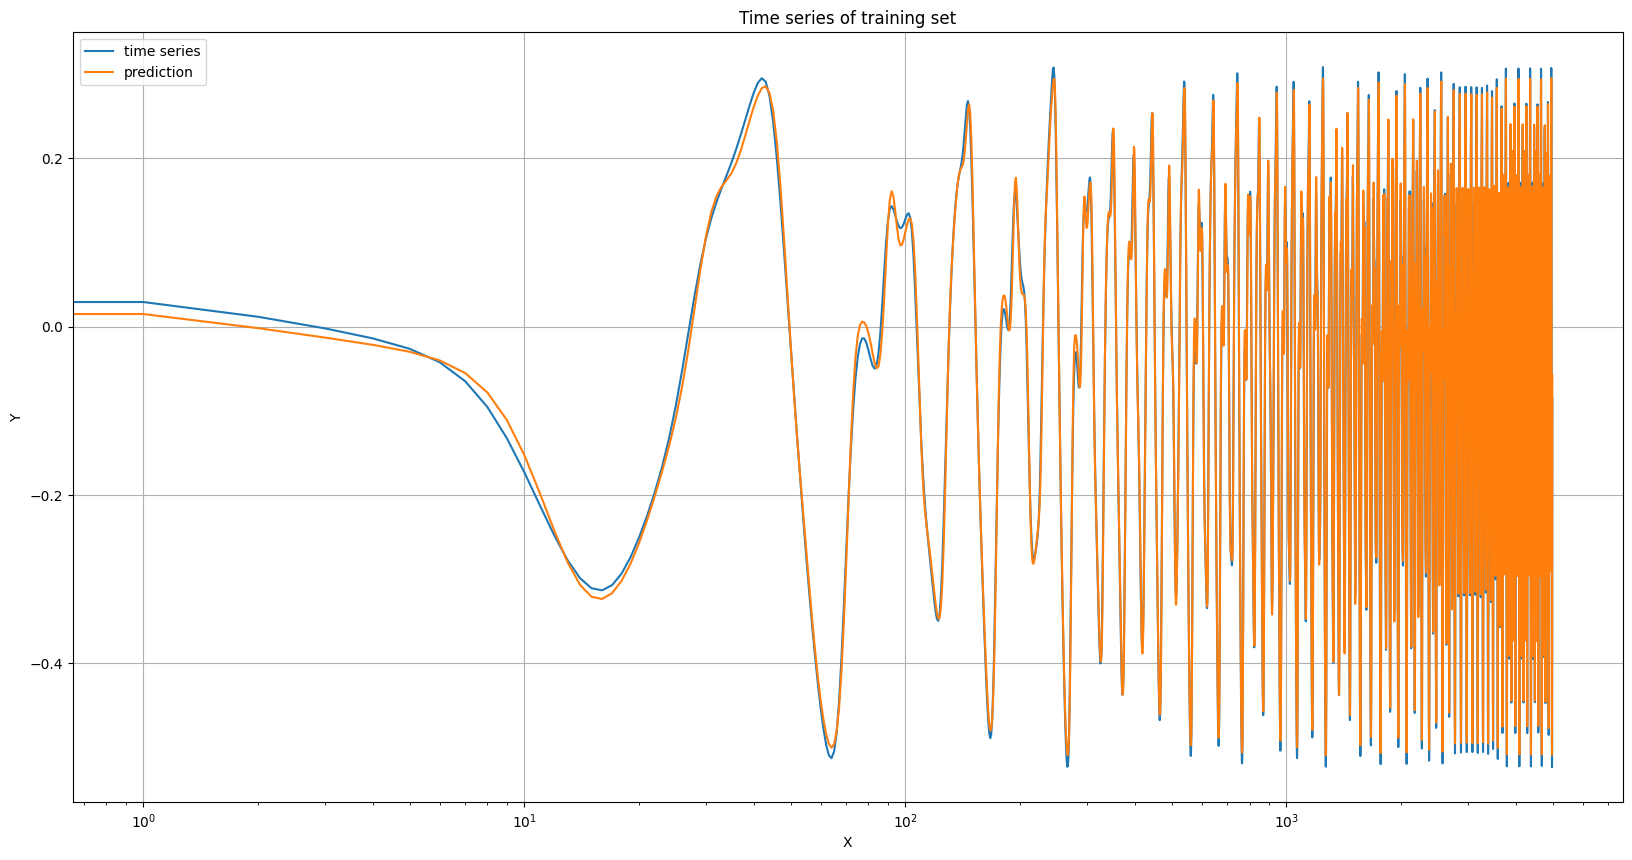

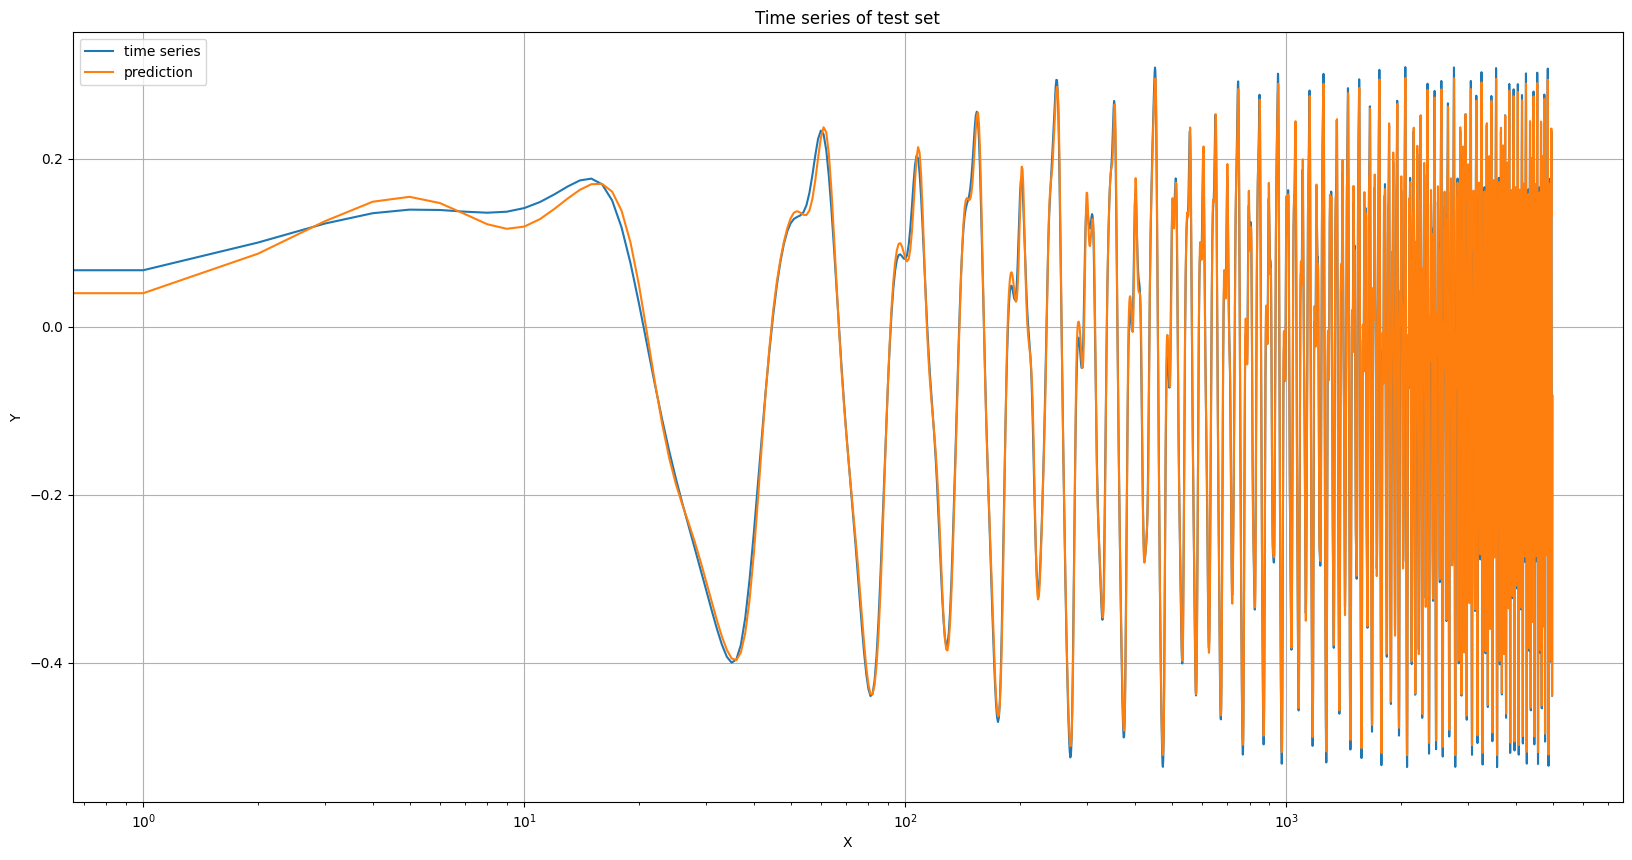

In [14]:
tdnn_save_name = 'tdnn_mg17'

tdnn_train_loss, tdnn_ts_loss, tdnn_train_pred, tdnn_eval_pred = gridsearch(
    train_func=train_tdnn,
    configs=dict(
        window=[8, 10, 12],
        hidden_size=[100],
        n_layers=[1, 2],
        lr=[0.1, 0.01],
        momentum=[0.5, 0.2],
    ),
    TR=(TR_X_mg17, TR_Y_mg17),
    TS=(TS_X_mg17, TS_Y_mg17),
    epochs=1000,
    vl_tr_size=4000,
    attempts_for_config=5,
    save_name=tdnn_save_name,
    device=device,
)

general_plot(tdnn_train_loss, tdnn_ts_loss, TR_Y_mg17.cpu(), tdnn_train_pred, TS_Y_mg17.cpu(), tdnn_eval_pred,
             save_name=tdnn_save_name)

### RNN

RNN gridsearch and results.

  0%|          | 0/8 [00:00<?, ?it/s]

1/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} with loss 0.00021593209627705315
2/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.00030529505844848853
3/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.5} with loss 0.00190628277293096
4/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.0034226808541764817
5/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.5} with loss 0.00023692499962635338
6/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.2} with loss 0.0003835805303727587
7/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.5} with loss 0.001972456695511937
8/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.2} with loss 0.003783527218426267
Best config: {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.5} 

  0%|          | 0/1000 [00:00<?, ?it/s]

{'train_mse': 0.0002455913636367768, 'validation_mse': 0.00021593209627705315, 'test_mse': 0.00024517442216165364}


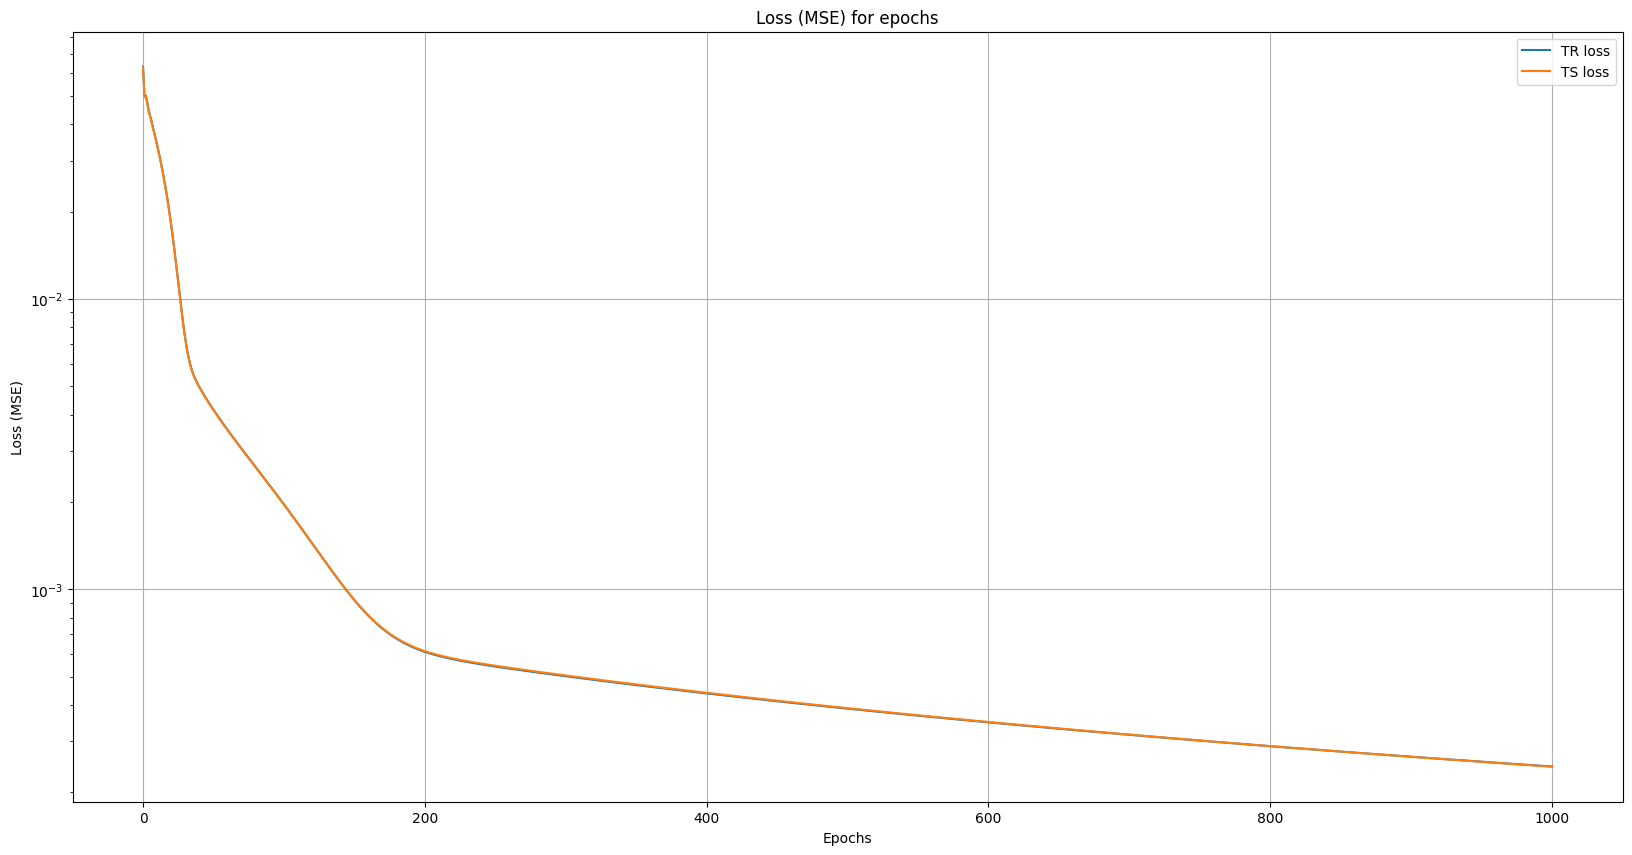

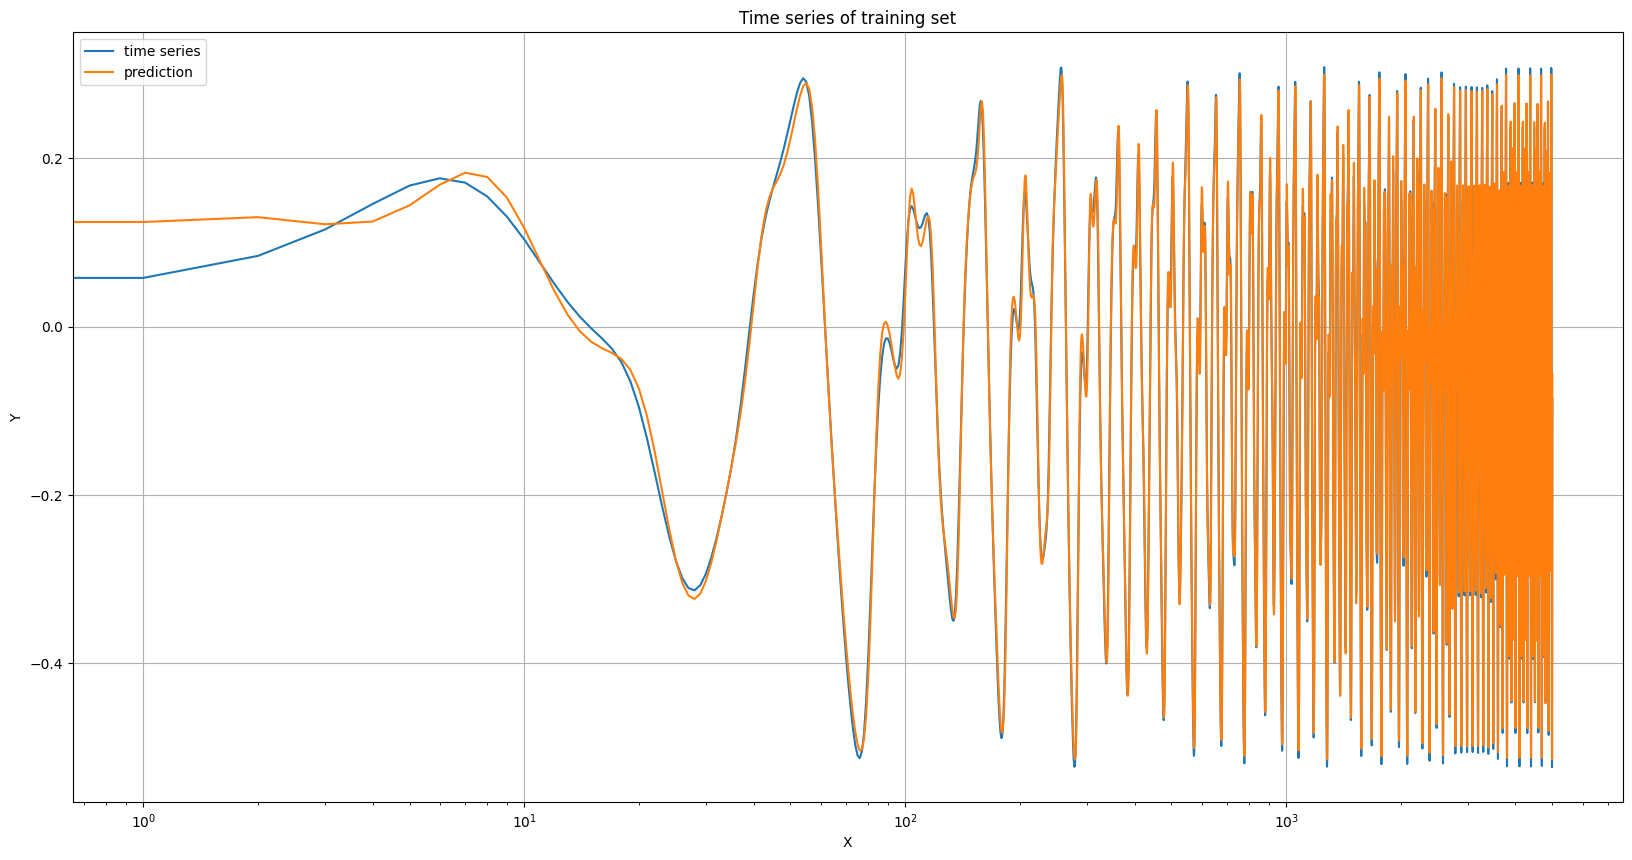

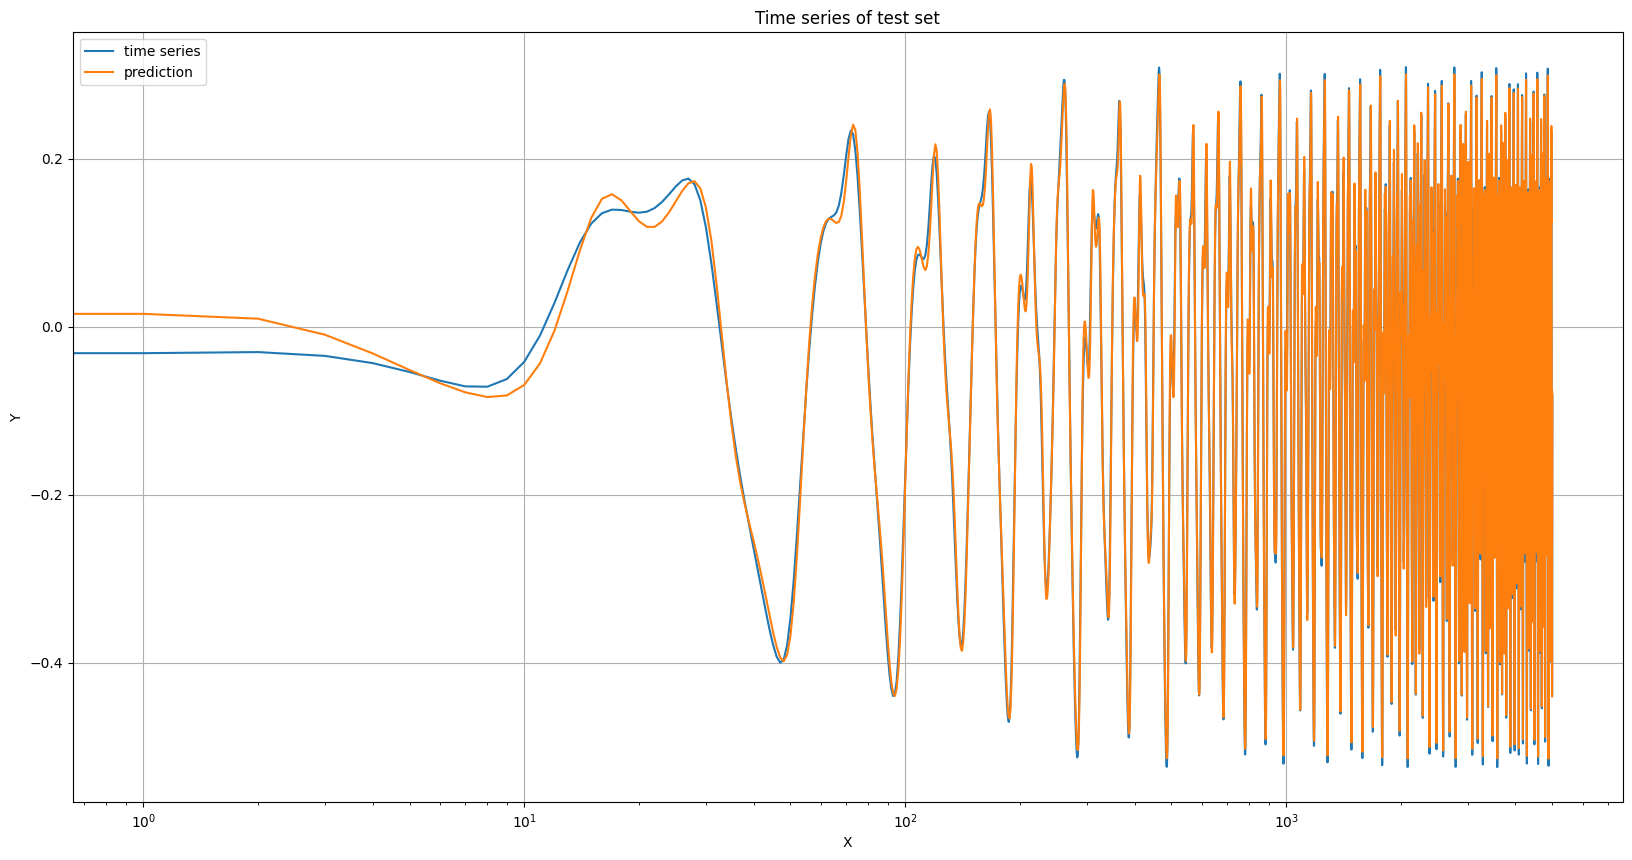

In [15]:
rnn_save_name = 'rnn_mg17'

rnn_train_loss, rnn_ts_loss, rnn_train_pred, rnn_eval_pred = gridsearch(
    train_func=train_rnn,
    configs=dict(
        hidden_size=[100],
        n_layers=[1, 2],
        lr=[0.1, 0.01],
        momentum=[0.5, 0.2],
    ),
    TR=(TR_X_mg17.reshape(-1, 1, 1), TR_Y_mg17.reshape(-1, 1, 1)),
    TS=(TS_X_mg17.reshape(-1, 1, 1), TS_Y_mg17.reshape(-1, 1, 1)),
    epochs=1000,
    vl_tr_size=4000,
    attempts_for_config=3,
    save_name=rnn_save_name,
    device=device,
)

general_plot(rnn_train_loss, rnn_ts_loss, TR_Y_mg17.cpu(), rnn_train_pred, TS_Y_mg17.cpu(), rnn_eval_pred,
             save_name=rnn_save_name)

# Bonus track 2 - Sequential MNIST classification task

Function able to download and get tensors related to MNIST data and labels of train and test set.

In [16]:
def download_mnist() -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Function able to download MNIST dataset and return it.

    returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: Training data and labels and test data and labels of MNIST dataset.
    """
    mnist_dir = 'MNIST/'
    if not Path(mnist_dir).exists():
        os.mkdir(mnist_dir)
    TR_MNIST = datasets.MNIST(root=f'{mnist_dir}', train=True, download=True, transform=None)
    TS_MNIST = datasets.MNIST(root=f'{mnist_dir}', train=False, download=True, transform=None)
    TR_DATA_MNIST = TR_MNIST.train_data.reshape(-1, 28 * 28).type(torch.float32).to(device)
    TS_DATA_MNIST = TS_MNIST.test_data.reshape(-1, 28 * 28).type(torch.float32).to(device)
    TR_LABELS_MNIST = torch.nn.functional.one_hot(TR_MNIST.train_labels).type(torch.float32).to(device)
    TS_LABELS_MNIST = torch.nn.functional.one_hot(TS_MNIST.test_labels).type(torch.float32).to(device)
    return TR_DATA_MNIST, TR_LABELS_MNIST, TS_DATA_MNIST, TS_LABELS_MNIST


TR_DATA_MNIST, TR_LABELS_MNIST, TS_DATA_MNIST, TS_LABELS_MNIST = download_mnist()

TR_DATA_MNIST.shape, TR_LABELS_MNIST.shape, TS_DATA_MNIST.shape, TS_LABELS_MNIST.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


(torch.Size([60000, 784]),
 torch.Size([60000, 10]),
 torch.Size([10000, 784]),
 torch.Size([10000, 10]))

Functions able to compute accuracy and plot a list of training and test accuracy for each epoch.

In [17]:
def accuracy(out: torch.Tensor, pred: torch.Tensor) -> float:
    """
    Function that compute accuracy given an output and prediction tensor.

    out: Output tensor.
    pred: Prediction tensor.

    returns:
        float: Computed accuracy value.
    """
    return (sum(pred.argmax(-1) - out.argmax(-1) == 0) / len(out)).item()


def plot_accuracy(train_accuracy: list, test_accuracy: list, save_name: str = None) -> None:
    """
    Function able to plot the accuracy for each epoch.

    train_accuracy: List of train accuracy for each epoch.
    test_accuracy: List of test accuracy for each epoch.
    """
    if save_name is not None:
        save_name = f'{save_name}_accuracy'
    _base_plot(
        [
            (train_accuracy, 'TR accuracy'),
            (test_accuracy, 'TS accuracy'),
        ],
        title='Accuracy for epochs',
        xlabel='Epochs',
        ylabel='Accuracy',
        save_name=save_name,
    )

Function able to perform RNN gridsearch and plot of results related to MSE loss and accuracy.

In [18]:
def perform_rnn_gs_and_plot(TR: tuple[torch.Tensor, torch.Tensor], TS: tuple[torch.Tensor, torch.Tensor], save_name: str) -> None:
    """
    Function able to perform RNN gridsearch and plot of results related to MSE loss and accuracy.

    TR: Training set.
    TS: Test set.
    save_name: Name given to the file where is saved the model.
    """
    rnn_train_loss, rnn_ts_loss, rnn_train_pred, rnn_eval_pred = gridsearch(
        train_func=train_rnn,
        configs=dict(
            hidden_size=[100],
            n_layers=[1, 2],
            lr=[0.1, 0.01],
            momentum=[0.9, 0.2],
        ),
        TR=TR,
        TS=TS,
        epochs=200,
        vl_tr_size=4000,
        attempts_for_config=1,
        save_name=save_name,
        device=device,
    )

    plot_loss(rnn_train_loss, rnn_ts_loss, save_name=save_name)

    tr_accuracy = [accuracy(TR[1].cpu(), pred) for pred in rnn_train_pred]
    ts_accuracy = [accuracy(TS[1].cpu(), pred) for pred in rnn_eval_pred]
    print(f'Accuracy: [TR: {tr_accuracy[-1]}] - [TS: {ts_accuracy[-1]}]')
    plot_accuracy(tr_accuracy,ts_accuracy,save_name=save_name)


Sequential MNIST model selection and model evaluation results.

  0%|          | 0/8 [00:00<?, ?it/s]

1/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.9} with loss 0.039984919130802155
2/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.05919642746448517
3/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.9} with loss 0.06099345535039902
4/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.14577616751194
5/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.9} with loss 0.04020070657134056
6/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.2} with loss 0.0621258020401001
7/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.9} with loss 0.06241864711046219
8/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.2} with loss 0.10058752447366714
Best config: {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.9} with loss 0.039984

  0%|          | 0/200 [00:00<?, ?it/s]

{'train_mse': 0.02458893693983555, 'validation_mse': 0.039984919130802155, 'test_mse': 0.02527867630124092}


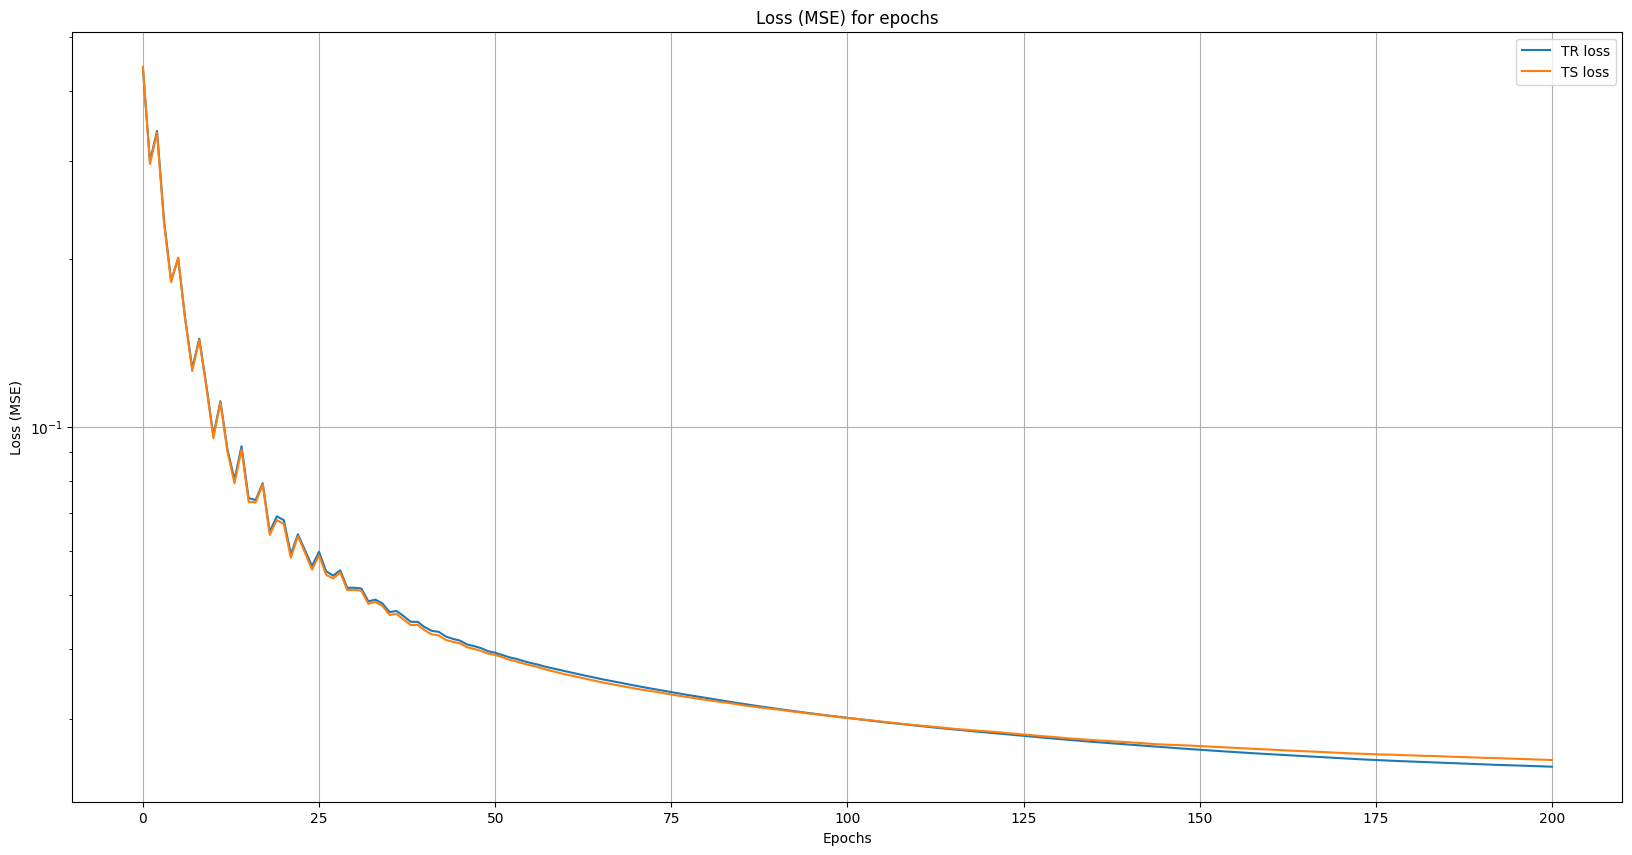

Accuracy: [TR: 0.8769833445549011] - [TS: 0.8723000288009644]


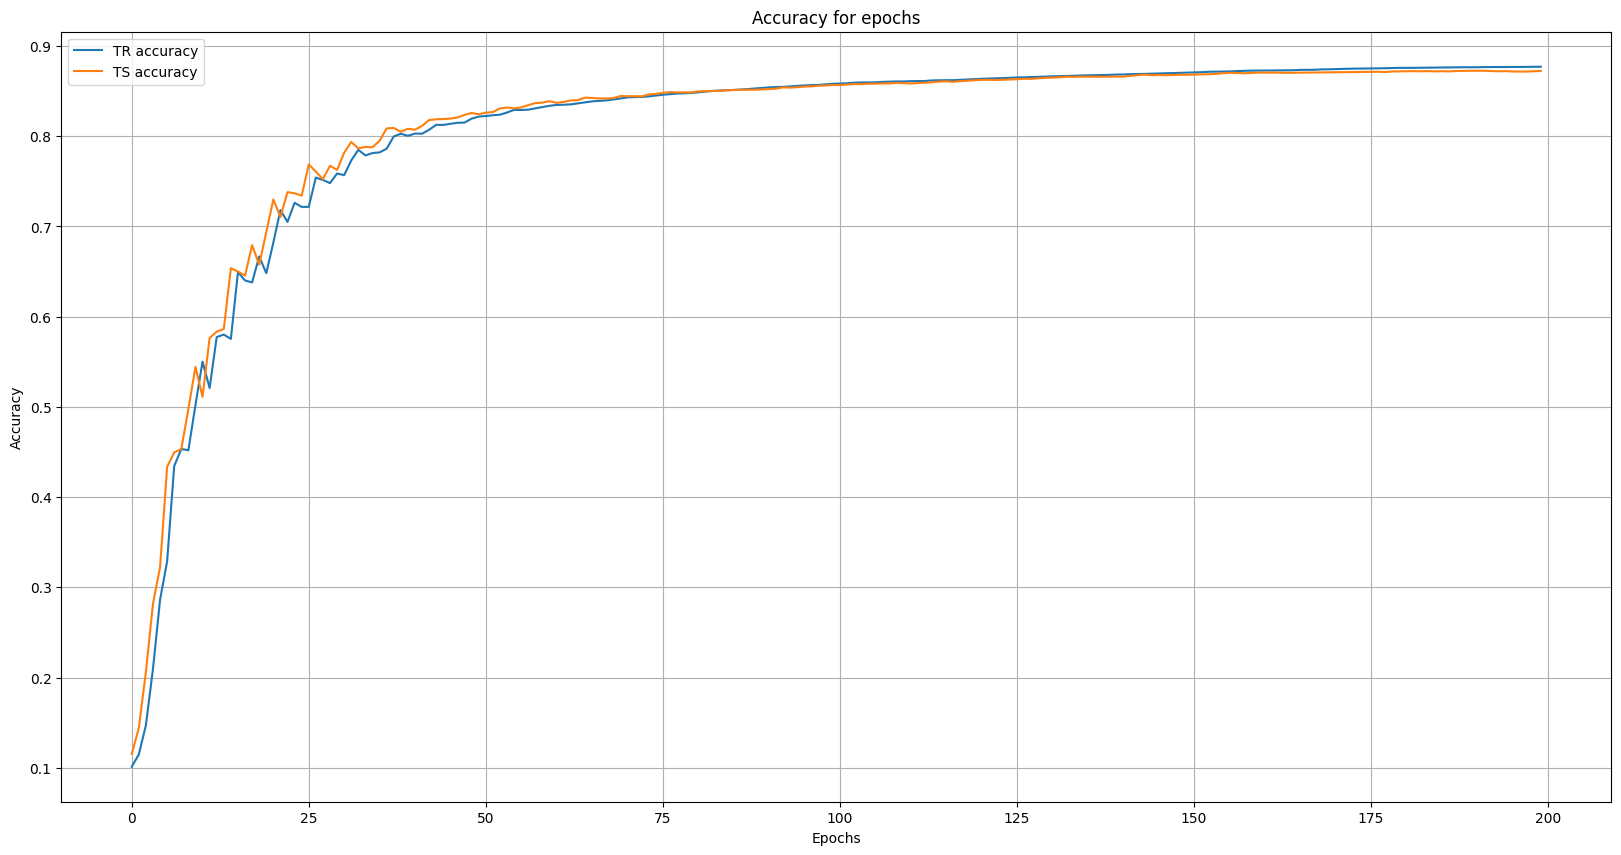

In [19]:
perform_rnn_gs_and_plot(
    (TR_DATA_MNIST, TR_LABELS_MNIST),
    (TS_DATA_MNIST, TS_LABELS_MNIST),
    save_name='rnn_seq_mnist'
)

MNIST dataset permutation od data to perform permuted sequential MNSIT.

In [20]:
permutations = np.random.permutation(28 * 28)

TR_DATA_PMNIST = TR_DATA_MNIST[:, permutations]
TS_DATA_PMNIST = TS_DATA_MNIST[:, permutations]

TR_DATA_PMNIST.shape, TS_DATA_PMNIST.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

Permuted MNIST model selection and model evaluation results.

  0%|          | 0/8 [00:00<?, ?it/s]

1/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.9} with loss 0.04048815742135048
2/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.2} with loss 0.05857974290847778
3/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.9} with loss 0.060342416167259216
4/8 - Tried config {'hidden_size': 100, 'n_layers': 1, 'lr': 0.01, 'momentum': 0.2} with loss 0.1429525464773178
5/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.9} with loss 0.04370741918683052
6/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.1, 'momentum': 0.2} with loss 0.06307149678468704
7/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.9} with loss 0.06308126449584961
8/8 - Tried config {'hidden_size': 100, 'n_layers': 2, 'lr': 0.01, 'momentum': 0.2} with loss 0.0978391021490097
Best config: {'hidden_size': 100, 'n_layers': 1, 'lr': 0.1, 'momentum': 0.9} with loss 0.0404

  0%|          | 0/200 [00:00<?, ?it/s]

{'train_mse': 0.025347644463181496, 'validation_mse': 0.04048815742135048, 'test_mse': 0.026247963309288025}


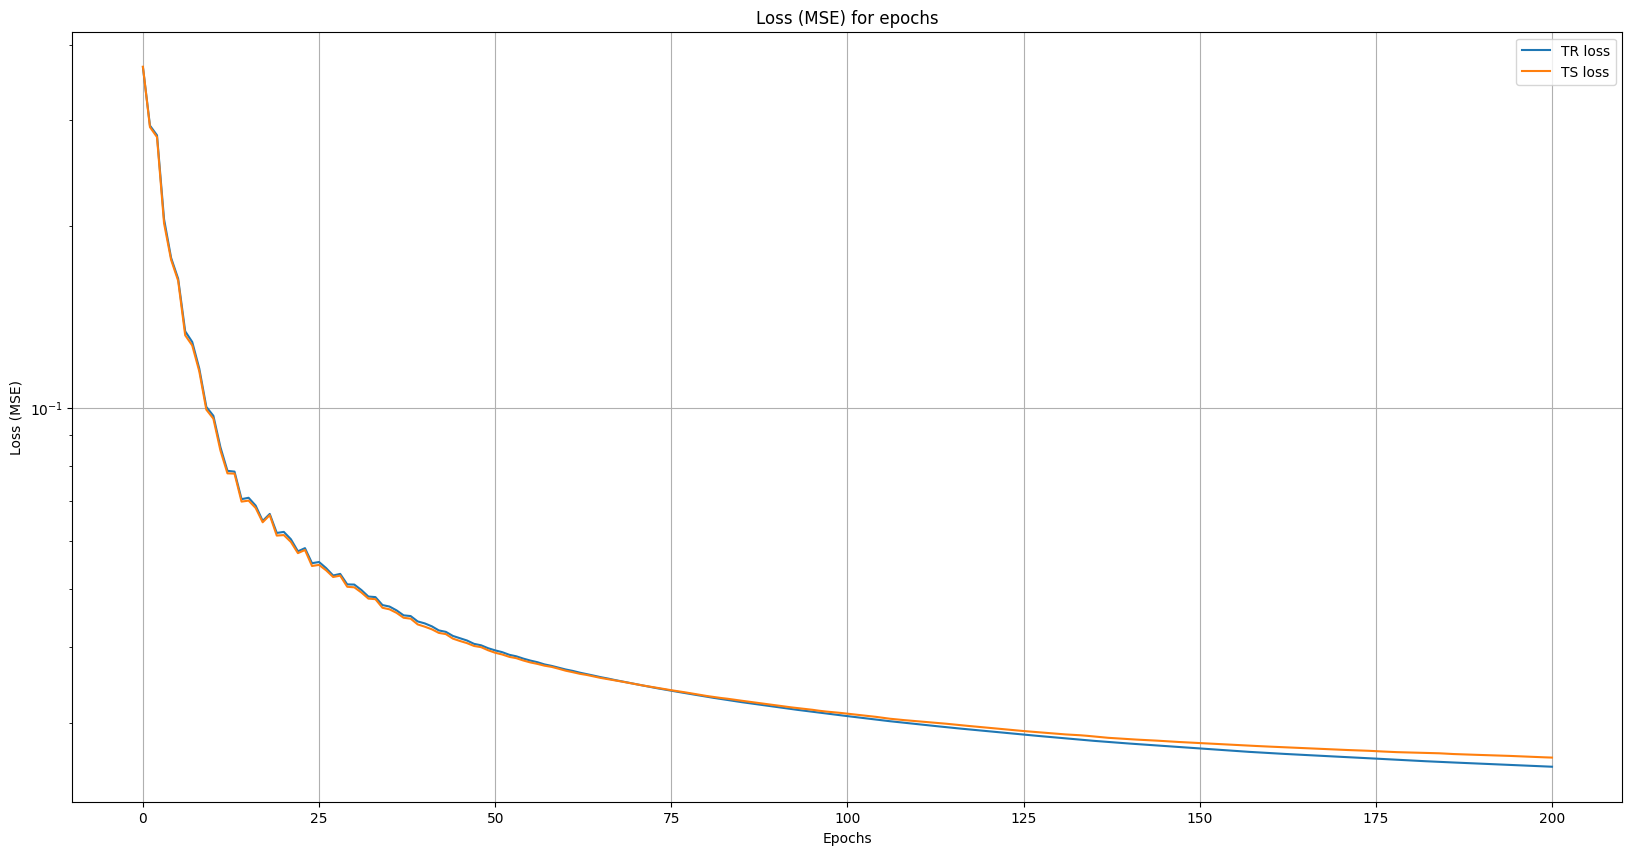

Accuracy: [TR: 0.8856666684150696] - [TS: 0.8758999705314636]


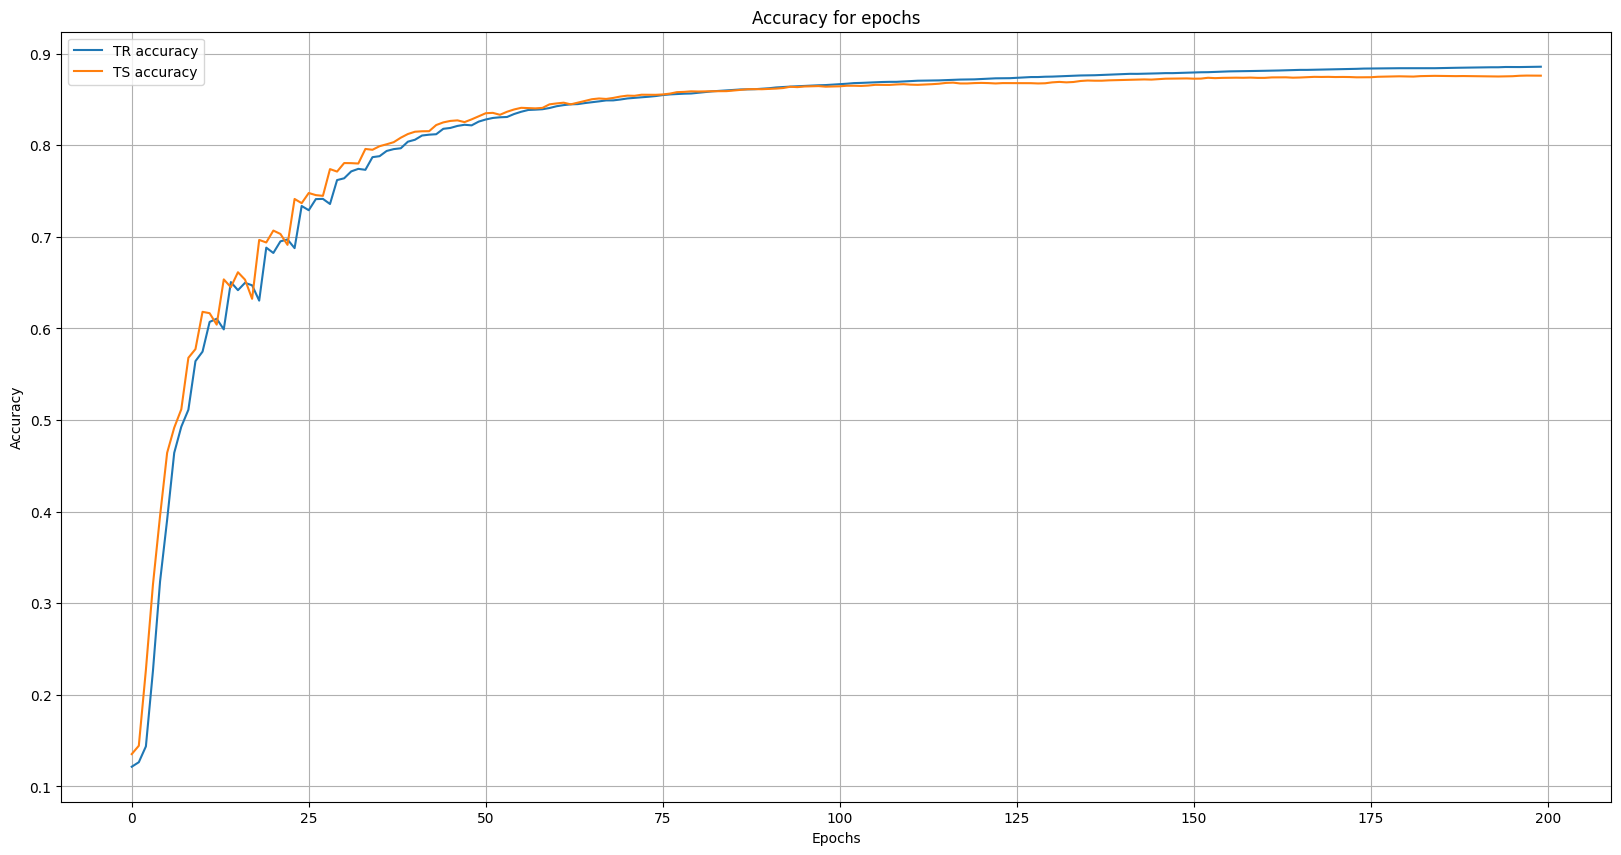

In [21]:
perform_rnn_gs_and_plot(
    (TR_DATA_PMNIST, TR_LABELS_MNIST),
    (TS_DATA_PMNIST, TS_LABELS_MNIST),
    save_name='rnn_permuted_mnist'
)